<h1> BBHs merging catalog generator </h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott](https://arxiv.org/abs/1811.12940).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Let's start by defining the probability distribution in function of the masses, we'll assume that the regime $m_{min} \leq m_{2} \leq m_{1} \leq m_{max}$ holds, hence the density distribution will represent the probability of having one BH in the mass range and the other with mass lower to the first one.
Due to the simmetry of the problem, the total number of events should be multiplied by 2.
We have :

In [2]:
# Function for estimating the Phase Space costant of the Mass distribution

def MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
        for j in range(len(ran_m2)- 1):
            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
                q = mid_m2/mid_m1 
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
              
    return ris

In [3]:
# Function for the distribution in function of mass

def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
        q = m2/m1
        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
    else :
        return 0.

Then, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [4]:
# Just a function to convert from Z to GPC using Hubble Law

def Z_to_Gpc(z):
    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 1

and the function that estimates the differential comoving volume in function of the redshift :

In [5]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z):
    r = Z_to_Gpc(z)    
    return (4.*np.pi*(r**2.))

Now let's define the auxiliary functions for the spin distribution density :

In [6]:
def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

and hence, the spin distribution module density is given by :

In [7]:
# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

In [8]:
# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

while the spin orientations distribution is given by :

In [9]:
# Spin orientation distribution, zeta = 1 gives a gaussian distribution centered in cos_ti = 1, zeta = 0 will return a isotropic distribution

def SpinOrientDistrib(cos_t1,cos_t2, zeta, sigma_1, sigma_2):
    prob = (1. - zeta)/(4) + ((2.*zeta)/(np.pi))*\
    (np.exp(-((np.power(1. - cos_t1,2.))/(2.*np.power(sigma_1,2.))))/(sigma_1*sc.erf(np.sqrt(2)/sigma_1)))\
    *(np.exp(-((np.power(1. - cos_t2,2.))/(2.*np.power(sigma_2,2.))))/(sigma_2*sc.erf(np.sqrt(2)/sigma_2)))
    return prob


We may finally define the distribution function for the number of events :

In [10]:
# Density function for the events in function of the parameters

def NDistrib(z,m1,m2,a_1,a_2,cos_t1,cos_t2):
    n = R_0*DeVC(z)*(T_obs/(1. + z)) \
    *MassDistr(m1,m2, m_min, m_max, alpha,beta_q, (1./MassPhaseSpace)) \
    *SpinModDistrib(a_1, alpha_a, beta_a, BetaVal)*SpinModDistrib(a_2, alpha_a, beta_a, BetaVal) \
    *SpinOrientDistrib(cos_t1, cos_t2, zeta, sigma_1, sigma_2)
    return n

and some other functions just to make the result appear sexier :

In [11]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    NId = random.randrange(999) + 1
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return 'GW'+ str(random.randrange(34,37))+ month + day + 'NId' + str(NId)


The global variables of the simulation will be set to :

In [12]:
# Flags for the execution modes

mode_ex = False
mode_fastmc = False

# Flag for the random seed selection

sel_rs = False

# Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

m_min = 5. # Solar Masses
m_max = 50. # Solar Masses
alpha = 1.6 # +-1.6 Big Error !
beta_q = 6.7 # +4.8 -5.9 Still Big Error !

#Spin Distribution parameter (values assumed considering the results of  arxiv 1811.12940)

Expected_a = 0.2 # Expected value for the spin amplitude a, < 0.5 with 90% confidence 
Var_a = 1./40.
a_max = 1.
alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)
sigma_1 = 5.
sigma_2 = 5.
zeta = 1. # For a gaussian distribution of the spin alignment 

# Merger distribution parameters

T_obs = 3. # years estimated of observation
R_0 = 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume
zmax = 0.5 # z value corrispondent to 2 gigaparsec

#General Constants 

c = 299792.46 # speed of light in Km/sec
H_0 = 67.8 # Hubble constant in Km/(s*MPc) 

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')

Let's plot the colormaps of the probability functions to check how they behave :

The integrated probability for all possible mass pairs is :  1.000000000000001


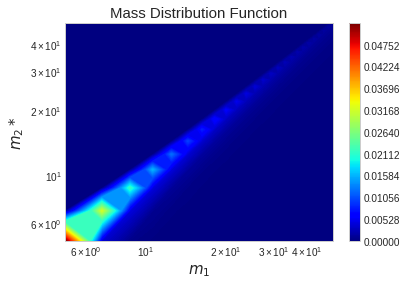

In [13]:
# Colormap of the mass distribution function

Z = np.zeros((25,25))
ran_m1 = np.linspace(m_min,m_max,25)
ran_m2 = np.linspace(m_min,m_max,25)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
X, Y = np.meshgrid(ran_m1, ran_m2)

for i in range(len(ran_m1)):
    for j in range(len(ran_m2)):
        Z[j][i] = MassDistr(X[j][i], Y[j][i], m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
        
plt.contourf(X, Y, Z, 1000, cmap='jet')
plt.colorbar();
plt.xlabel(r'$m_1$', fontsize = 15)
plt.ylabel(r'$m_2*$', fontsize = 15)
plt.title('Mass Distribution Function', fontsize = 15)
plt.loglog()

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_m1)-1):
    for j in range(len(ran_m2)-1):
        totprob += (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*MassDistr(st.mean([ran_m1[i],ran_m1[i+1]]), st.mean([ran_m2[j],ran_m2[j+1]]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))

print('The integrated probability for all possible mass pairs is : ', totprob) 

The integrated probability for all possible spin amplitudes is :  1.0000000000000007


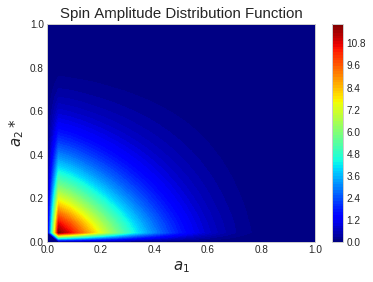

In [14]:
# Colormap of the spin amplitude distribution function

Z = np.zeros((25,25))
ran_a1 = np.linspace(0.,a_max,25)
ran_a2 = np.linspace(0.,a_max,25)
BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
X, Y = np.meshgrid(ran_a1, ran_a2)

for i in range(len(ran_a1)):
    for j in range(len(ran_a2)):
        Z[j][i] = SpinModDistrib(X[j][i], alpha_a, beta_a, BetaVal)*SpinModDistrib(Y[j][i], alpha_a, beta_a, BetaVal)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$a_1$', fontsize = 15)
plt.ylabel(r'$a_2*$', fontsize = 15)
plt.title('Spin Amplitude Distribution Function', fontsize = 15)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_a1)-1):
    for j in range(len(ran_a2)-1):
        totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

print('The integrated probability for all possible spin amplitudes is : ', totprob)        

The integrated probability for all possible tilt angles is :  1.000021940340117


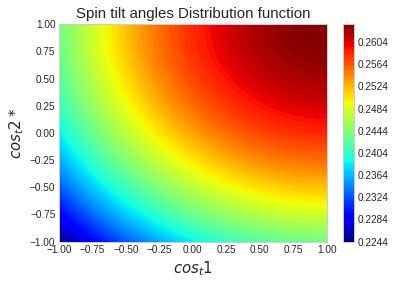

In [15]:
# Colormap of the spin tilt distribution function

Z = np.zeros((25,25))
ran_cos_t1 = np.linspace(-1.,1.,25)
ran_cos_t2 = np.linspace(-1.,1.,25)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1)):
    for j in range(len(ran_cos_t2)):
        Z[j][i] = SpinOrientDistrib(X[j][i], Y[j][i], zeta, sigma_1, sigma_2)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$cos_t1$', fontsize = 15)
plt.ylabel(r'$cos_t2*$', fontsize = 15)
plt.title('Spin tilt angles Distribution function', fontsize = 15)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_cos_t1)-1):
    for j in range(len(ran_cos_t2)-1):
        totprob += (ran_cos_t1[i + 1] - ran_cos_t1[i])*(ran_cos_t2[j + 1] - ran_cos_t2[j])*SpinOrientDistrib(st.mean([ran_cos_t1[i],ran_cos_t1[i + 1]]), st.mean([ran_cos_t2[j],ran_cos_t2[j + 1]]), zeta, sigma_1, sigma_2)

print('The integrated probability for all possible tilt angles is : ', totprob)


The simulation will be spanned over the following range of variables :

In [16]:
ran_m1 = np.linspace(m_min,m_max,25)
ran_m2 = np.linspace(m_min,m_max,25)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
ran_z = np.linspace(0.,zmax, 5)    # Don't put bins too small or the volume wouldn't be enough to generate events
ran_a_1 = np.linspace(0., a_max,5)
ran_a_2 = np.linspace(0., a_max,5)
BetaVal = Beta_Func(ran_a_1, alpha_a, beta_a)
ran_cos_t1 = np.linspace(-1.,1.,4)
ran_cos_t2 = np.linspace(-1.,1.,4)

and the result will be saved in the BHCat dataframe :

In [17]:
BHCat = pd.DataFrame(columns=['EventName', 'Distance_GPc','Coal_Time', 'Coal_Phase', 'Declination', 'RightAscension', 'Inclination', 'Mass1', 'Mass2', 'Spin_a1', 'Spin_a2', 'cos_t1', 'cos_t2', 'Polarization' ])

In [18]:
# Example of the format of an added merging event
#BH= pd.DataFrame([['GW321312',1.1,520,4.56,0.6,0.8,2.35,22,18, 0.2,0., 0.4, -0.6, 5.81],], columns=['EventName', 'Distance_GPc','Coal_Time', 'Coal_Phase', 'Declination', 'RightAscension', 'Inclination', 'Mass1', 'Mass2', 'Spin_a1', 'Spin_a2', 'cos_t1', 'cos_t2', 'Polarization' ])

The standard way of simulating the events will generate the same number of events in the same range of variables every time it was run...
To give to the simulation a little bit of randomness, and allow the generation of merging events with exotic range of variable, set the **exotic_mode** flags to true. 

In [19]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one flag may be setup at a single time !**

In [20]:
mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

Furthermore, you may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [21]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

We may finally launch the pipeline to generate the merging events in the considered volume :

In [22]:
Nev = 0
Nreal = 0.

# Checking if flags variable are correct
if(mode_fastmc and mode_ex):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_fastmc !')
    mode_ex = False
        
for im1 in range(len(ran_m1)-1):
    print('Percentage of completition :',(100.*ran_m1[im1]/m_max))
    for im2 in (range(im1)):
        for iz in range(len(ran_z) - 1):
            for ia_1 in range(len(ran_a_1)-1):
                for ia_2 in range(len(ran_a_2)-1):
                    for ict1 in range(len(ran_cos_t1)-1):
                        for ict2 in range(len(ran_cos_t2)-1):
                            # estimating the value of NDistrib in function of the values, the value will be interpolated with the trapeze method
                            nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]),st.mean([ran_m1[im1],ran_m1[im1 + 1]]),st.mean([ran_m2[im2],ran_m2[im2 + 1]]),st.mean([ran_a_1[ia_1],ran_a_1[ia_1 + 1]])\
                                     ,st.mean([ran_a_2[ia_2],ran_a_2[ia_2 + 1]]),st.mean([ran_cos_t1[ict1],ran_cos_t1[ict1 + 1]]),st.mean([ran_cos_t2[ict2],ran_cos_t2[ict2 + 1]]))
                            # to obtain the real result of the integral, we now need to multiply for the 2 factor due to the mass distribution and for the values of the delta of all the integration variables  
                            nstep *= 2.*Z_to_Gpc(ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])*(ran_a_1[ia_1 + 1] - ran_a_1[ia_1])*(ran_a_2[ia_2 + 1] - ran_a_2[ia_2])\
                                     *(ran_cos_t1[ict1 + 1] - ran_cos_t1[ict1])*(ran_cos_t2[ict2 + 1] - ran_cos_t2[ict2])
                           
                            # Addint the fraction of events to the cumulative sum
                            
                            Nreal += nstep 
                            
                            # Checking if mode_fast_mc and implementing
                                                        
                            if(mode_fastmc):
                                if(nstep >=1.):
                                    if(nstep - round(nstep) >= 0):
                                        res = nstep - round(nstep)
                                        if(np.random.random() <= res):
                                            nstep = round(nstep) + 1.
                                    else:
                                        res = nstep + 1. - round(nstep)
                                        if(np.random.random() >= res):
                                            nstep = round(nstep) - 1.
                                else:
                                        if(np.random.random() <= nstep):
                                            nstep = 1.
                            
                            # Checking if mode exotic
                                        
                            if(mode_ex):
                                nstep += (np.random.random()*0.5)
                                
                            # The value need to be round up to an integer
                            nstep = round(nstep)
                            Nev += int(nstep)
                            for i in range(int(nstep)):
                                # Generate random values in the phase volume for each of the found events 
                                ev_nm = Gen_Event_name()
                                ev_dst = Z_to_Gpc(random.uniform(ran_z[iz],ran_z[iz + 1]))
                                ev_coatime = random.uniform(0., 1000)
                                ev_coaphase = random.uniform(0., 2.*np.pi)
                                ev_dec = random.uniform(-(0.5*np.pi),0.5*np.pi)
                                ev_ra = random.uniform(0.,2.*np.pi)
                                ev_inc = random.uniform(0., np.pi) 
                                ev_m1 = random.uniform(ran_m1[im1],ran_m1[im1 + 1])
                                if(ran_m2[im2 + 1] > ev_m1):
                                    ev_m2 = random.uniform(ran_m2[im2],ev_m1)
                                else:
                                    ev_m2 = random.uniform(ran_m2[im2],ran_m2[im2 + 1])
                                ev_sa1 = random.uniform(ran_a_1[ia_1],ran_a_1[ia_1 + 1])
                                ev_sa2 = random.uniform(ran_a_2[ia_2],ran_a_2[ia_2 + 1])
                                ev_st1 = random.uniform(ran_cos_t1[ict1],ran_cos_t1[ict1 + 1])
                                ev_st2 = random.uniform(ran_cos_t2[ict2],ran_cos_t2[ict2 + 1])
                                ev_plrz = random.uniform(0., 2.*np.pi)
                                BH = pd.DataFrame([[ev_nm,ev_dst,ev_coatime,ev_coaphase,ev_dec,ev_ra,ev_inc,ev_m1,ev_m2,ev_sa1,ev_sa2,ev_st1,ev_st2,ev_plrz],],\
                                                  columns = ['EventName', 'Distance_GPc','Coal_Time', 'Coal_Phase', 'Declination', 'RightAscension', 'Inclination', 'Mass1', 'Mass2', 'Spin_a1', 'Spin_a2', 'cos_t1', 'cos_t2', 'Polarization' ])
                                BHCat = BHCat.append(BH, sort = False)
                            
print('During the simulation, ', Nev, ' merging events where generated over the ',int(round(Nreal)), ' predicted')
# Saving the Dataframe

BHCat.set_index('EventName', inplace = True)
BHCat = BHCat.sort_index(axis=0)

if(mode_ex):
    BHCat.to_csv('BHCatalogueExotic.csv', index_label = 'EventName')
else:
    if(mode_fastmc):
        BHCat.to_csv('BHCatalogueMC.csv', index_label = 'EventName')
    else:
        BHCat.to_csv('BHCatalogue.csv', index_label = 'EventName')

Percentage of completition : 10.0
Percentage of completition : 13.75
Percentage of completition : 17.5
Percentage of completition : 21.25
Percentage of completition : 25.0
Percentage of completition : 28.75
Percentage of completition : 32.5
Percentage of completition : 36.25
Percentage of completition : 40.0
Percentage of completition : 43.75
Percentage of completition : 47.5
Percentage of completition : 51.25
Percentage of completition : 55.0
Percentage of completition : 58.75
Percentage of completition : 62.5
Percentage of completition : 66.25
Percentage of completition : 70.0
Percentage of completition : 73.75
Percentage of completition : 77.5
Percentage of completition : 81.25
Percentage of completition : 85.0
Percentage of completition : 88.75
Percentage of completition : 92.5
Percentage of completition : 96.25
During the simulation,  4393  merging events where generated over the  4052  predicted


The final dataframe appear as follow:

In [23]:
BHCat

,Distance_GPc,Coal_Time,Coal_Phase,Declination,RightAscension,Inclination,Mass1,Mass2,Spin_a1,Spin_a2,cos_t1,cos_t2,Polarization
EventName,,,,,,,,,,,,,
GW340101NId311,2.175638,510.478008,1.732503,0.482981,2.252165,0.032061,14.047532,10.212118,0.266507,0.717037,-0.641087,0.032176,6.177951
GW340101NId509,0.868503,445.578039,5.071668,-1.159114,3.213956,2.246801,36.852047,32.296199,0.018066,0.009768,-0.104686,0.861093,6.276698
GW340101NId623,1.790528,828.346824,3.003490,-1.459580,1.309042,1.640762,38.264182,29.915867,0.195217,0.120779,-0.660051,0.786371,5.339124
GW340101NId970,0.754301,661.836543,5.544920,1.108852,1.794507,1.325734,40.042983,36.648513,0.136930,0.327733,-0.362933,-0.210681,5.245887
GW340102NId18,1.640597,706.812255,5.244035,0.902470,1.658386,1.878712,14.000568,10.749230,0.093398,0.119848,-0.488035,0.579717,4.796557
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GW361228NId228,1.552306,673.639314,4.528637,-1.221088,5.812284,2.300157,21.597515,18.468815,0.239110,0.507224,-0.672184,0.249389,0.683045
GW361228NId292,1.898216,662.136830,4.825881,-0.531677,5.292777,3.107030,33.121906,28.588438,0.091041,0.188456,0.431820,-0.559305,2.937870
GW361228NId433,1.902217,839.848626,1.922726,0.909844,1.529873,1.957483,43.164974,23.067874,0.223304,0.197460,-0.116922,0.832707,4.158399


Let's check the properties of that by doing a scatter plot of masses : 

Text(0, 0.5, 'Mass 2 (Solar Mass)')

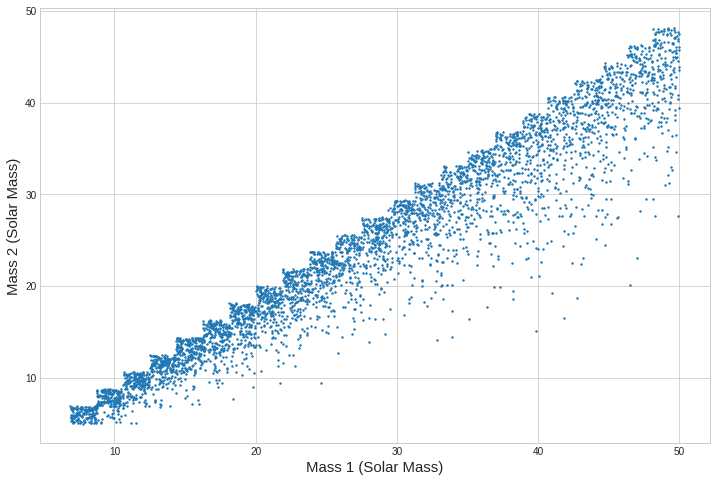

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Mass1'], BHCat['Mass2'], s=2)
plt.xlabel('Mass 1 (Solar Mass)', fontsize = 15)
plt.ylabel('Mass 2 (Solar Mass)', fontsize = 15)

Let's also do a scatter plot for the spin amplitude and orientation :

Text(0, 0.5, 'Second spin amplitude a2')

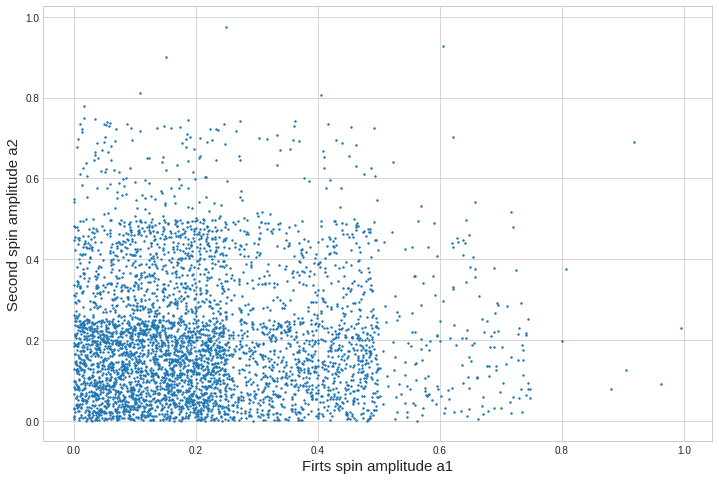

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Spin_a1'], BHCat['Spin_a2'], s=2)
plt.xlabel('Firts spin amplitude a1', fontsize = 15)
plt.ylabel('Second spin amplitude a2', fontsize = 15)

Text(0, 0.5, 'Second spin orientation (cos_t2)')

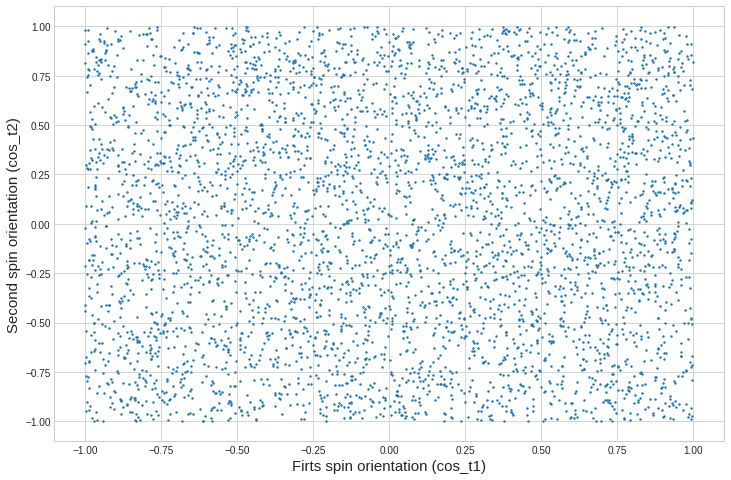

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['cos_t1'], BHCat['cos_t2'], s=2)
plt.xlabel('Firts spin orientation (cos_t1)', fontsize = 15)
plt.ylabel('Second spin orientation (cos_t2)', fontsize = 15)

They seems to follow the distribution functions showed before !